## Prepare packages

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Disable annoying warnings in some packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import multiprocessing

In [4]:
# Scaling and dimensionality reduction
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [5]:
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import classification_report

In [8]:
from time import time

In [9]:
from scipy.stats import randint as sp_randint

In [10]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# ML algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC

In [11]:
import pylab as plt

In [12]:
import eli5

## Data

### Read packages

In [13]:
data = pd.read_csv('dataset_aggr.csv')

### List available columns

In [14]:
data.columns

Index(['UserID', 'ItemID', 'avg_rating', 'number_of_unique_songs',
       'number_of_unique_genres', 'genre_ratio', 'main_genre_dominance',
       'no_stimulus_points', 'stimulus_points',
       'driving_style_relaxed_driving', 'driving_style_sport_driving',
       'landscape_coast_line', 'landscape_country_side', 'landscape_mountains',
       'landscape_urban', 'mood_active', 'mood_happy', 'mood_lazy', 'mood_sad',
       'natural_phenomena_afternoon', 'natural_phenomena_day_time',
       'natural_phenomena_morning', 'natural_phenomena_night',
       'road_type_city', 'road_type_highway', 'road_type_serpentine',
       'sleepiness_awake', 'sleepiness_sleepy', 'traffic_conditions_free_road',
       'traffic_conditions_lots_of_cars', 'traffic_conditions_traffic_jam',
       'weather_cloudy', 'weather_rainy', 'weather_snowing', 'weather_sunny',
       'category_name_blues', 'category_name_classical',
       'category_name_country', 'category_name_disco', 'category_name_hip_hop',
       'c

## Prepare data

### Set label column 

In [15]:
data['label'] = 1

### Add negative samples

We are going to continually sample random N-items from our groups, and keep items if they are not positive. This will continue until we have enough negative samples.

In [16]:
dataset = data.copy()

for idx, row in data.iterrows():
    # new_row = {'UserID': row['UserID'], }
    candidate = data[(data.ItemID != row['ItemID']) & (data.UserID != row['UserID'])].sample(n=1)
    candidate = candidate.iloc[0].to_dict()
    
    left_k = ['UserID', 'number_of_unique_songs',
       'number_of_unique_genres', 'genre_ratio', 'main_genre_dominance',
       'no_stimulus_points', 'stimulus_points',
       'driving_style_relaxed_driving', 'driving_style_sport_driving',
       'landscape_coast_line', 'landscape_country_side', 'landscape_mountains',
       'landscape_urban', 'mood_active', 'mood_happy', 'mood_lazy', 'mood_sad',
       'natural_phenomena_afternoon', 'natural_phenomena_day_time',
       'natural_phenomena_morning', 'natural_phenomena_night',
       'road_type_city', 'road_type_highway', 'road_type_serpentine',
       'sleepiness_awake', 'sleepiness_sleepy', 'traffic_conditions_free_road',
       'traffic_conditions_lots_of_cars', 'traffic_conditions_traffic_jam',
       'weather_cloudy', 'weather_rainy', 'weather_snowing', 'weather_sunny', 
       'dominant_genre_blues',
       'dominant_genre_pop', 'dominant_genre_rock', 'second_dominant_blues',
       'second_dominant_blues_classical_disco',
       'second_dominant_blues_classicalsecond_dominant_hh',
       'second_dominant_blues_disco_rock', 'second_dominant_blues_hh',
       'second_dominant_blues_metal_reggae', 'second_dominant_classical',
       'second_dominant_classical_country',
       'second_dominant_classical_country_disco_hh',
       'second_dominant_classical_country_disco_hh_jazz_metal_rock',
       'second_dominant_classical_disco',
       'second_dominant_classical_disco_reggae',
       'second_dominant_classical_hh_rock', 'second_dominant_country',
       'second_dominant_country_disco_rock',
       'second_dominant_country_jazz_rock', 'second_dominant_disco',
       'second_dominant_disco_hh', 'second_dominant_jazz',
       'second_dominant_metal']
    
    right_k = ['ItemID', 'category_name_blues', 'category_name_classical',
       'category_name_country', 'category_name_disco', 'category_name_hip_hop',
       'category_name_jazz', 'category_name_metal', 'category_name_pop',
       'category_name_reggae', 'category_name_rock']
    
    left = { k: row[k] for k in left_k }
    right = { k: candidate[k] for k in right_k }
    
    new_row = {**left, **right}
    new_row['avg_rating'] = None
    new_row['label'] = 0
    
    dataset = dataset.append(new_row, ignore_index=True)

### Investigate first rows

In [17]:
dataset.sort_values(by='UserID').head(20)

,UserID,ItemID,avg_rating,number_of_unique_songs,number_of_unique_genres,genre_ratio,main_genre_dominance,no_stimulus_points,stimulus_points,driving_style_relaxed_driving,...,second_dominant_classical_disco_reggae,second_dominant_classical_hh_rock,second_dominant_country,second_dominant_country_disco_rock,second_dominant_country_jazz_rock,second_dominant_disco,second_dominant_disco_hh,second_dominant_jazz,second_dominant_metal,label
0,1001.0,251.0,2.25,10.0,6.0,0.1,0.4,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
932,1001.0,254.0,NaN,10.0,6.0,0.2,0.4,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
933,1001.0,288.0,NaN,10.0,6.0,0.1,0.4,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
934,1001.0,289.0,NaN,10.0,6.0,0.4,0.4,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
935,1001.0,723.0,NaN,10.0,6.0,0.1,0.4,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
936,1001.0,680.0,NaN,10.0,6.0,0.2,0.4,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
937,1001.0,746.0,NaN,10.0,6.0,0.4,0.4,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
938,1001.0,286.0,NaN,10.0,6.0,0.4,0.4,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
939,1001.0,692.0,NaN,10.0,6.0,0.4,0.4,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
931,1001.0,272.0,NaN,10.0,6.0,0.1,0.4,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [18]:
dataset.label.describe()

count    1860.000000
mean        0.500000
std         0.500134
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: label, dtype: float64

### Basics statistics of all columns

In [19]:
dataset.describe()

,UserID,ItemID,avg_rating,number_of_unique_songs,number_of_unique_genres,genre_ratio,main_genre_dominance,no_stimulus_points,stimulus_points,driving_style_relaxed_driving,...,second_dominant_classical_disco_reggae,second_dominant_classical_hh_rock,second_dominant_country,second_dominant_country_disco_rock,second_dominant_country_jazz_rock,second_dominant_disco,second_dominant_disco_hh,second_dominant_jazz,second_dominant_metal,label
count,1860.000000,1860.000000,930.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,...,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000,1860.000000
mean,1019.140860,552.851075,2.373441,64.984946,8.132258,0.394187,0.589208,0.986022,1.088172,0.194624,...,0.016129,0.005376,0.016129,0.010753,0.010753,0.682796,0.012903,0.016129,0.005376,0.500000
std,11.319058,217.574781,1.275900,48.312411,2.640507,0.271442,0.102053,0.868316,0.862069,0.404085,...,0.126006,0.073146,0.126006,0.103164,0.103164,0.465513,0.112887,0.126006,0.073146,0.500134
min,1001.000000,248.000000,0.000000,1.000000,1.000000,0.010101,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1009.000000,281.000000,1.000000,20.000000,6.000000,0.080000,0.542857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1019.000000,692.000000,2.250000,70.000000,10.000000,0.542857,0.567308,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000
75%,1032.000000,730.000000,3.250000,116.000000,10.000000,0.600000,0.637931,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1042.000000,762.000000,5.000000,139.000000,10.000000,1.000000,1.000000,5.000000,5.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Check for NA values

In [20]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

In [21]:
missing_value_df

,column_name,percent_missing
UserID,UserID,0.0
ItemID,ItemID,0.0
avg_rating,avg_rating,50.0
number_of_unique_songs,number_of_unique_songs,0.0
number_of_unique_genres,number_of_unique_genres,0.0
genre_ratio,genre_ratio,0.0
main_genre_dominance,main_genre_dominance,0.0
no_stimulus_points,no_stimulus_points,0.0
stimulus_points,stimulus_points,0.0
driving_style_relaxed_driving,driving_style_relaxed_driving,0.0


we're going to remove avg rating from the set, otherwise algorithm may convergence to it unneccesary

## Prepare train-test sets

In [22]:
X = dataset.drop(['UserID', 'ItemID', 'label', 'avg_rating'], axis=1).values
Y = dataset.label.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

In [23]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_X_train = imp.fit_transform(X_train)

In [24]:
imp_X_test = imp.transform(X_test)

## First model - reconnaissance

In [25]:
clf = GradientBoostingClassifier()
clf.fit(imp_X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
y_pred = clf.predict(imp_X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.52      0.64       186
         1.0       0.65      0.90      0.76       186

    accuracy                           0.71       372
   macro avg       0.75      0.71      0.70       372
weighted avg       0.75      0.71      0.70       372



In [28]:
explaination = eli5.sklearn.explain_prediction.explain_prediction_tree_classifier(clf, 
                                                                                  imp_X_test[0], 
                                                                                  top=imp_X_test.shape[1])

In [29]:
explaination

Explanation(estimator="GradientBoostingClassifier(criterion='friedman_mse', init=None,\n                           learning_rate=0.1, loss='deviance', max_depth=3,\n                           max_features=None, max_leaf_nodes=None,\n                           min_impurity_decrease=0.0, min_impurity_split=None,\n                           min_samples_leaf=1, min_samples_split=2,\n                           min_weight_fraction_leaf=0.0, n_estimators=100,\n                           n_iter_no_change=None, presort='auto',\n                           random_state=None, subsample=1.0, tol=0.0001,\n                           validation_fraction=0.1, verbose=0,\n                           warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='x34', weight=0.45406965128098853, std=None, value=1.0), FeatureWeight(feature='x39', weight=0.28801540591629265, std=None, value=0.0), FeatureWeight(feature='x2', weight=0.16814315574688404, std=None, value=0.027027027027027032), FeatureWeight(feature='x0', weight=0.010257769211239484, std=None, value=70.0), FeatureWeight(feature='x25', weight=0.005919765543995774, std=None, value=0.0), FeatureWeight(feature='x41', weight=0.004774022939780384, std=None, value=0.0), FeatureWeight(feature='x14', weight=0.0023523662080805986, std=None, value=0.0), FeatureWeight(feature='x40', weight=0.0021779965109458804, std=None, value=0.0), FeatureWeight(feature='x11', weight=0.0021652676749300266, std=None, value=0.0), FeatureWeight(feature='x51', weight=0.0021208676801999734, std=None, value=0.0), FeatureWeight(feature='x4', weight=0.001798357545885216, std=None, value=0.0), FeatureWeight(feature='x17', weight=0.0016364390050485147, std=None, value=0.0), FeatureWeight(feature='x30', weight=0.0011970220662823683, std=None, value=0.0), FeatureWeight(feature='x7', weight=0.0007653480441942893, std=None, value=0.0), FeatureWeight(feature='x15', weight=0.0007181938836814676, std=None, value=0.0), FeatureWeight(feature='x6', weight=0.000464581338015105, std=None, value=0.0), FeatureWeight(feature='x54', weight=0.0003991909542091974, std=None, value=0.0), FeatureWeight(feature='x64', weight=0.00013473844657350698, std=None, value=0.0), FeatureWeight(feature='x62', weight=0.00012982153178830652, std=None, value=0.0), FeatureWeight(feature='x58', weight=0.00010806730466270253, std=None, value=0.0)], neg=[FeatureWeight(feature='x3', weight=-0.1082613670435878, std=None, value=0.472972972972973), FeatureWeight(feature='x36', weight=-0.018924559432490353, std=None, value=0.0), FeatureWeight(feature='x35', weight=-0.01858917732837507, std=None, value=0.0), FeatureWeight(feature='x22', weight=-0.016636622326940475, std=None, value=1.0), FeatureWeight(feature='x37', weight=-0.016029379534942954, std=None, value

## Compare different algorithms

### Check recall

In [30]:
# prepare models
models = []
# initial_pca = 3
n_splits = 6  # k=6 folds

# hyper-parameter tuning will be done later
models.append(('ETC', Pipeline([('prepare', StandardScaler()), ('clf', ExtraTreesClassifier(n_jobs=-1))])))
models.append(('GBC', Pipeline([('prepare', StandardScaler()), ('clf', GradientBoostingClassifier())])))
models.append(('ADA', Pipeline([('prepare', StandardScaler()), ('clf', AdaBoostClassifier())])))
models.append(('RFC', Pipeline([('prepare', StandardScaler()), ('clf', RandomForestClassifier(n_jobs=-1))])))
models.append(('PAC', Pipeline([('prepare', StandardScaler()), ('clf', PassiveAggressiveClassifier(n_jobs=-1))])))
models.append(('SGD', Pipeline([('prepare', StandardScaler()), ('clf', SGDClassifier(n_jobs=-1))])))
models.append(('MLP', Pipeline([('prepare', StandardScaler()), ('clf', MLPClassifier())])))
models.append(('SVC', Pipeline([('prepare', StandardScaler()), ('clf', SVC())])))
models.append(('HGBC', Pipeline([('prepare', StandardScaler()), ('clf', HistGradientBoostingClassifier())])))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

In [31]:
left = len(models)

for name, model in models:
    left -= 1
    print('Testing the {} algorithm, there are {} methods left'.format(name, left))
    kfold = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, random_state=42)
    cv_results = model_selection.cross_val_score(model, X, Y, 
                                                 cv=kfold, 
                                                 n_jobs=-1, 
                                                 verbose=0,
                                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Testing the ETC algorithm, there are 8 methods left
ETC: 0.458280 (0.049260)
Testing the GBC algorithm, there are 7 methods left
GBC: 0.899892 (0.026744)
Testing the ADA algorithm, there are 6 methods left
ADA: 0.362903 (0.042234)
Testing the RFC algorithm, there are 5 methods left
RFC: 0.386774 (0.055040)
Testing the PAC algorithm, there are 4 methods left
PAC: 0.496882 (0.077897)
Testing the SGD algorithm, there are 3 methods left
SGD: 0.455161 (0.071070)
Testing the MLP algorithm, there are 2 methods left
MLP: 0.497957 (0.042771)
Testing the SVC algorithm, there are 1 methods left
SVC: 0.645376 (0.043915)
Testing the HGBC algorithm, there are 0 methods left
HGBC: 0.737204 (0.039206)


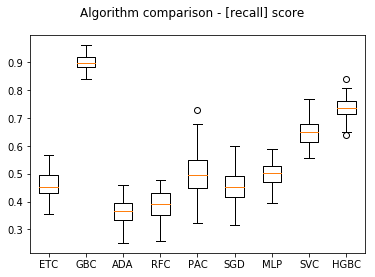

In [32]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm comparison - [recall] score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Precision

In [33]:
# evaluate each model in turn
results = []
names = []
scoring = 'precision'

left = len(models)

for name, model in models:
    left -= 1
    print('Testing the {} algorithm, there are {} methods left'.format(name, left))
    kfold = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, random_state=42)
    cv_results = model_selection.cross_val_score(model, X, Y, 
                                                 cv=kfold, 
                                                 n_jobs=-1, 
                                                 verbose=0,
                                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Testing the ETC algorithm, there are 8 methods left
ETC: 0.482273 (0.034198)
Testing the GBC algorithm, there are 7 methods left
GBC: 0.652199 (0.014958)
Testing the ADA algorithm, there are 6 methods left
ADA: 0.361060 (0.025805)
Testing the RFC algorithm, there are 5 methods left
RFC: 0.433869 (0.041405)
Testing the PAC algorithm, there are 4 methods left
PAC: 0.489113 (0.032032)
Testing the SGD algorithm, there are 3 methods left
SGD: 0.483659 (0.023081)
Testing the MLP algorithm, there are 2 methods left
MLP: 0.509918 (0.025834)
Testing the SVC algorithm, there are 1 methods left
SVC: 0.511466 (0.017596)
Testing the HGBC algorithm, there are 0 methods left
HGBC: 0.617201 (0.017736)


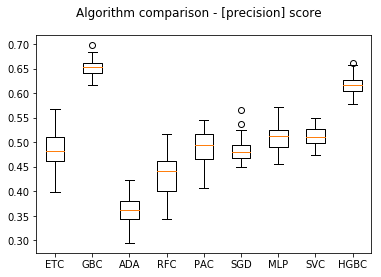

In [34]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm comparison - [precision] score')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hyper-parameter tuning

In [35]:
# Utility function to report best scores after hypertuning
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [36]:
param_dist = dict(scale=[StandardScaler(), StandardScaler(with_std=False), 
                         SimpleImputer(missing_values=np.nan, strategy='mean'), MinMaxScaler()],
                  clf=[GradientBoostingClassifier(), ],
                  clf__loss=['deviance', 'exponential'], 
                  clf__learning_rate=[0.01, 0.005, 0.02, 0.05, 0.01, 0.02], 
                  clf__n_estimators=[100, 50, 200, 150, 250],
                  clf__subsample=[0.8, 1.0, 0.9, 0.7],
                  clf__criterion=['mse', 'friedman_mse'],
                  clf__min_samples_leaf=[1, 2, 3],
                  clf__max_depth=[2,3,4],
                  clf__max_features=[None, 'auto', 'sqrt', 'log2'],
                  clf__min_samples_split=[2, 3, 0.5, 4])

pipe = Pipeline(steps=[('scale', None), ('clf', None)])

# Optimizing through F1
scoring_tune='f1'

# Run randomized search
n_iter_search = 250
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=param_dist,
                                   scoring=scoring_tune,
                                   n_iter=n_iter_search,
                                   verbose=True,
                                   cv=model_selection.RepeatedStratifiedKFold(n_splits=6, n_repeats=2),
                                   n_jobs=multiprocessing.cpu_count())

start = time()
random_search.fit(X, Y)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

Fitting 12 folds for each of 250 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 110 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 262 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 512 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 883 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1333 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 1883 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 2533 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:  5.8min finished


RandomizedSearchCV took 349.34 seconds for 250 candidates parameter settings.


In [37]:
best = random_search.best_estimator_

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.790 (std: 0.013)
Parameters: {'scale': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0), 'clf__subsample': 0.9, 'clf__n_estimators': 50, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 3, 'clf__max_features': 'auto', 'clf__max_depth': 4, 'clf__loss': 'exponential', 'clf__learning_rate': 0.005, 'clf__criterion': 'friedman_mse', 'clf': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='exponential', max_depth=4,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_sta

In [40]:
eli5.sklearn.explain_prediction.explain_prediction_tree_classifier(best['clf'], 
                                                                   imp_X_test[0], 
                                                                   top=imp_X_test.shape[1])

Explanation(estimator="GradientBoostingClassifier(criterion='friedman_mse', init=None,\n                           learning_rate=0.005, loss='exponential', max_depth=4,\n                           max_features='auto', max_leaf_nodes=None,\n                           min_impurity_decrease=0.0, min_impurity_split=None,\n                           min_samples_leaf=3, min_samples_split=2,\n                           min_weight_fraction_leaf=0.0, n_estimators=50,\n                           n_iter_no_change=None, presort='auto',\n                           random_state=None, subsample=0.9, tol=0.0001,\n                           validation_fraction=0.1, verbose=0,\n                           warm_start=False)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='x2', weight=0.09297964792025075, std=None, value=0.027027027027027032), FeatureWeight(feature='x35', weight=0.048075725781794136, std=None, value=0.0), FeatureWeight(feature='x5', weight=0.016875432262966294, std=None, value=0.0), FeatureWeight(feature='x0', weight=0.013769271318050317, std=None, value=70.0), FeatureWeight(feature='x23', weight=0.003896364518975538, std=None, value=0.0), FeatureWeight(feature='x61', weight=0.00386140428651492, std=None, value=1.0), FeatureWeight(feature='x37', weight=0.003343542204026348, std=None, value=0.0), FeatureWeight(feature='x3', weight=0.002416183728597019, std=None, value=0.472972972972973), FeatureWeight(feature='<BIAS>', weight=0.00023131636530083843, std=None, value=1.0), FeatureWeight(feature='x7', weight=6.502193269323008e-05, std=None, value=0.0), FeatureWeight(feature='x33', weight=1.7014363956852683e-05, std=None, value=0.0), FeatureWeight(feature='x47', weight=1.4248415914866744e-05, std=None, value=0.0), FeatureWeight(feature='x53', weight=1.213958392684335e-05, std=None, value=0.0), FeatureWeight(feature='x46', weight=9.134188301087014e-06, std=None, value=0.0), FeatureWeight(feature='x10', weight=8.800580507866842e-06, std=None, value=0.0), FeatureWeight(feature='x57', weight=3.4795227688353746e-07, std=None, value=0.0)], neg=[FeatureWeight(feature='x39', weight=-0.0617933867234604, std=None, value=0.0), FeatureWeight(feature='x34', weight=-0.02086256606918507, std=None, value=1.0), FeatureWeight(feature='x40', weight=-0.0003671022775619154, std=None, value=0.0), FeatureWeight(feature='x41', weight=-0.000181628163010721, std=None, value=0.0), FeatureWeight(feature='x59', weight=-1.4341431004595135e-05, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.5510003018438322, score=0.10235657073983108, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)